# PCA - Principal Component Analysis

### Table of Contents   
   

* [Dimensionality reduction](#DimensionalityReduction)


* [Step by step eigendecomposition PCA with numpy](#PCAnumpy)


* [Scikit-learn PCA function with iris dataset](#ScikitLearn)

___    
___   



###  <a id='DimensionalityReduction'> Dimensionality reduction </a>

Dimensionality reduction is a technique to go from an $n$-dimensional space to another one with $m\leq n$.   
Data-wise it means going from a number of variables n to $m\leq n$ variables that explain as much as possible the variability of the original dataset, eg data can be projected from a 3D space into a lower 2D with minimal information loss. 
   
Why do we want to select the variables with most variability? Because this is usually a hint for a signal, while small variability hints for the variable to just be noise. So features with more varaibility will likely be better predictors for the target variable.          
   
A simple dimensionality reduction technique can be __feature seelection__: eliminating some variables will result in a smaller dataset feature space. In this way though, any potential benefit the eliminated variables could bring gets lost.   
  
With __feature extraction__ instead, new variables are created as combination of the existing ones so .   
  
PCA is used to extract a limited number of uncorrelated features combining together highly correlated variables from a bigger number of variables available in a dataset.    
       
Compared to features selection, feature extraction like PCA will get to a smaller feature dataset but all the variables will still be there, so information coming from them will not be lost.      


* __Eigendecomposition__
* __Singular Value Decomposition__


Most PCA implementations perform a Singular Value Decomposition (SVD) to improve the computational efficiency.    We will see the Eigendecomposition.

With PCA the principal components are looked for according to the following two properties:
 * Maximise the variance along the new component
 * Minimise error between original point and projected one 
 
NB Normalize before finding the PC otherwise the principal component will be biased toward to largest scale variable.     
  

In a simple example of two highly correlated variables like petal width and petal length one can think to go from 2 variables data to just one variable with minor information loss. In this case the principal component that we will use as new predictor will be the line defined by a regression.



In [161]:
# ---- FUNCTION TO HIDE CELL CODE ----#

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide upper code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

Most correlated variables: 
 petal width   petal length    0.962865
petal length  petal width     0.962865
type          petal width     0.956547
petal width   type            0.956547
petal length  type            0.949035
dtype: float64


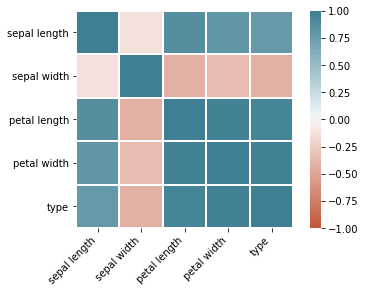

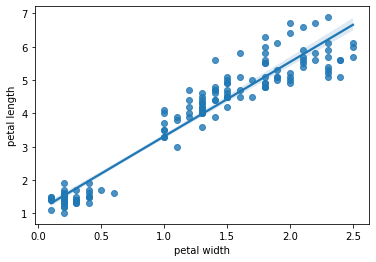

In [162]:
# ---- Read the dataset, calculate column correlations and make a seaborn heatmap ---- #

import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import datasets

# import iris data
iris_data = datasets.load_iris()
#convert to dataframe
df_iris = pd.DataFrame(iris_data['data'],
                       columns=["sepal length","sepal width","petal length","petal width"])
# add column with iris type
df_iris['type'] = pd.Series(iris_data["target"])

df_iris_corr = df_iris.corr()

#Pivot a level of the index labels.
piv_corr = df_iris_corr[df_iris_corr!=1].unstack() 
#sort correlation values in decresing order
sort_piv_corr = piv_corr.sort_values(ascending=False)
print("Most correlated variables:","\n", sort_piv_corr.head())

# ---- correlation heatmap ---- #

data = df_iris

corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=1
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

# scatterplot with regression line
sns.regplot(x=df_iris["petal width"], y=df_iris["petal length"])
plt.show()

hide_toggle()

__Terminology__    
Eigen vectors: direction of the principal component    
Eigen value: Amount of variance explained         

__Why PCA?__    
PCA reduces the dimension of the features space thus resulting in a better computational efficiency but it helps also in preventing overfitting because a model will have to consider fewer variables then fewer relationships to catch.


**PROS**
* Reduced number of new variables 
* Computational efficiency
* Independence of new variables (principal components will be orthogonal)
  
**CONS**
* Less interpretable predictors (linear combinations of original independent variables)
  

###  <a id='PCAnumpy'> Step by step PCA with numpy </a>

### Import numpy library and necessary functions 

In [163]:
import numpy as np
from numpy import array, mean, cov
from numpy.linalg import eig

### Define a matrix

In [164]:
A = array([[1, 2], [3, 4], [5, 6]])
A

array([[1, 2],
       [3, 4],
       [5, 6]])

### PCA 
#### 1) calculate the mean of each column

In [165]:
M = mean(A.T, axis=1)
M

array([3., 4.])

#### 2) center columns by subtracting column means
This means subtracting the column mean value from each value of the column

In [166]:
C = A - M
C

array([[-2., -2.],
       [ 0.,  0.],
       [ 2.,  2.]])

##### 2.b) Standardize &rarr; compute standard deviation for each column and divide by that value 
NB Follow this step only if the importance of the variables is independent of their variance

Z = C / $\sigma$

#### 3) calculate covariance matrix of centered (or standardized) matrix
3.1 Transpose $C^t$   
3.2 Multiply transposed by centered  $C^t C$ = covariance matrix     
The covariance matrix contains estimates of correlation of one variable to any other variable

In [167]:
V = cov(C.T)
V

array([[4., 4.],
       [4., 4.]])

#### 4) Eigendecomposition of covariance matrix
We decompose the covariance matrix into $EDE⁻¹$     
$C^t C$ &rarr; $EDE⁻¹$     
    
With $E$ = Eigenvector matrix     
$D$ = Eigenvalues matrix     
$E⁻¹$ = Inverse Eigenvector matrix     

The i-th column of E, an eigen vector, will be associated with the first element of the diagonal of D which is the first eigenvalue: $\lambda_1 = D_{1,1}$ 

In [168]:
values, vectors = eig(V)
print(vectors)
print(values)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[8. 0.]


Sort the eigenvalues $\lambda_1, \lambda_2, ... \lambda_n$ from biggest to smallest and also the eigenvectors accordingly (the columns of E).    
Thus we will have $E_s$ = sorted eigenvectors matrix.   
We can consider the eigenvalues as weights of the eigenvectors so to select only the ones with bigger eigenvalues thus reducing the number of dimensions.

#### 5) Project data

In [169]:
# project data
P = vectors.T.dot(C.T)
print(P.T)

[[-2.82842712  0.        ]
 [ 0.          0.        ]
 [ 2.82842712  0.        ]]


###  <a id='ScikitLearn'> Scikit learn function with Iris dataset</a>

In [170]:
from numpy import array
from sklearn.decomposition import PCA

#### Small matrix example

In [171]:
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
A

array([[1, 2],
       [3, 4],
       [5, 6]])

From [scikit learn PCA() documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html):  
The parameter n_components is the number of components to keep, by default all components are kept.

In [173]:
# create the PCA instance
pca = PCA(n_components=2) #Number of components to keep. Default -> all components kept
# fit on data
pca.fit(A)
# access values and vectors
print("Principal components:\n", pca.components_)
print("\nPrincipal components values:\n", pca.explained_variance_)

Principal components:
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

Principal components values:
 [8.00000000e+00 2.25080839e-33]


In [174]:
# transform data
B = pca.transform(A)
B

array([[-2.82842712e+00,  2.22044605e-16],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.82842712e+00, -2.22044605e-16]])

#### Real case: iris data

In [189]:
# import iris data
iris_arr = datasets.load_iris()['data']
# standardize
iris_arr_std = StandardScaler(with_mean=True, with_std=True).fit_transform(iris_arr)

# create the PCA instance
pca = PCA(n_components=None)  #Number of components to keep. Default -> all components kept

#components = pca.transform(faces.data)
#projected = pca.inverse_transform(components)

# fit model with iris data 
pca.fit(iris_arr_std)

#Apply dimensionality reduction to X to get all the observations in the new system
# of "principal" coordinates 
pc_data = pca.transform(iris_arr_std)

#We can fit and trasform at once with PCA().fit_transform()
#Fit the model with X and apply the dimensionality reduction on X.
pc_data = PCA().fit_transform(iris_arr_std)

# access values and vectors
print("Principal components (eigenvectors):\n", pca.components_)
print("\nPrincipal components values (eigenvalues):\n", pca.explained_variance_)

Principal components (eigenvectors):
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]
 [-0.71956635  0.24438178  0.14212637  0.63427274]
 [-0.26128628  0.12350962  0.80144925 -0.52359713]]

Principal components values (eigenvalues):
 [2.93808505 0.9201649  0.14774182 0.02085386]


### How many principal components? &rarr; Explained variance and scree plot
The total variance is the sum of the sample variances of each individual new variable. Dividing each individual variance by the total we see how much each variable 'explains' (account for) the total.   
The scree plot represents the cumulative explained variance and helps to find the right number of  principal components to be kept.

Amount of variance explained by each of the selected components: 
 [2.93808505 0.9201649  0.14774182 0.02085386] 

Percentage of variance explained by each of the selected components: 
 [0.72962445 0.22850762 0.03668922 0.00517871]


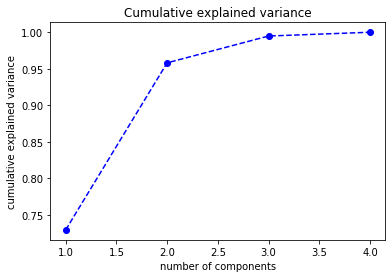

In [182]:
#amount of variance explained by each of the selected components
print("Amount of variance explained by each of the selected components:","\n",
      pca.explained_variance_, "\n")

#Percentage of variance explained by each of the selected components.
print("Percentage of variance explained by each of the selected components:","\n", 
      pca.explained_variance_ratio_)

#Plot cumulative explained variance
plt.plot(np.arange(1,5), np.cumsum(pca.explained_variance_ratio_),
         linestyle='--', marker='o', color='b')

plt.title("Cumulative explained variance")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

hide_toggle()

###### From the plot we see that the first two principal components explain more than 95% of the variance so we can choose n=2

With the sklearn function inverse_transform(self, X) we also can transform data back to its original space.

TO CHECK:
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
- http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/118-principal-component-analysis-in-r-prcomp-vs-princomp/
    